데이터 전처리

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import konlpy
from konlpy.tag import Okt
import numpy as np

In [2]:
train_data=pd.read_csv('D:\\ai\\기말대체\\Data set_1.csv')
test_data=pd.read_csv('D:\\ai\\기말대체\\Data set_2.csv')

In [3]:
stopwords=['로','에','등','으로','및','과','되며','한']

In [4]:
okt=Okt()
X_train=[]
for sentence in train_data['title']:
    temp_X=[]
    temp_X=okt.morphs(sentence,stem=True)
    temp_X=[word for word in temp_X if not word in stopwords]
    X_train.append(temp_X)
X_test=[]
for sentence in test_data['title']:
    temp_X=[]
    temp_X=okt.morphs(sentence,stem=True)
    temp_X=[word for word in temp_X if not word in stopwords]
    X_test.append(temp_X)

In [5]:
print(X_train[:3])

[['CMG', '제약', '외국인', '12만', '9000', '주', '순', '매수', '주가', '058'], ['CMG', '제약', '외국인', '8만', '6000', '주', '순', '매수', '주가', '246'], ['CMG', '제약', '검색', '상위', '랭킹', '주가', '159']]


In [6]:
print(X_test[:3])

[['fnRASSI', '씨', '케이', '에이치', '900120', '1185', '상승'], ['fnRASSI', '씨', '케이', '에이치', '900120', '899', '상승'], ['코스닥', '人', '씨', '케이', '에이치', '화장품', '·', '건기', '식', '사업', '두', '마리', '토끼', '잡다']]


토큰화한 단어를 정수인코딩

In [7]:
from keras.preprocessing.text import Tokenizer
max_words=35000
tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train=tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)

Using TensorFlow backend.


In [8]:
print(X_train[:3])

[[105, 70, 22, 858, 583, 8, 18, 20, 4, 859], [105, 70, 22, 860, 584, 8, 18, 20, 4, 585], [105, 70, 44, 50, 51, 4, 445]]


In [9]:
print(X_test[:3])

[[12, 66, 180, 202, 1897, 1], [12, 66, 180, 202, 1897, 1], [35, 66, 180, 202, 763, 5, 662, 65, 1292]]


label data -1,0,1에 대해서 one hot encoding

In [10]:
y_train=[]
y_test=[]

for i in range(len(train_data['label'])):
    if train_data['label'].iloc[i]==1:
        y_train.append([0,0,1])
    elif train_data['label'].iloc[i]==0:
        y_train.append([0,1,0])
    elif train_data['label'].iloc[i]==-1:
        y_train.append([1,0,0])

for i in range(len(test_data['label'])):
    if test_data['label'].iloc[i]==1:
        y_test.append([0,0,1])
    elif test_data['label'].iloc[i]==0:
        y_test.append([0,1,0])
    elif test_data['label'].iloc[i]==-1:
        y_test.append([1,0,0])
        
y_train=np.array(y_train)
y_test=np.array(y_test)

In [11]:
y_train

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [12]:
y_test

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]])

딥러닝 earlystopping callback적용한 모델2

In [13]:
from keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.callbacks import ModelCheckpoint,EarlyStopping

np.random.seed(3)
tf.random.set_seed(3)

max_len=20
X_train=pad_sequences(X_train, maxlen=max_len)
X_test=pad_sequences(X_test,maxlen=max_len)

In [18]:
model3 = Sequential()
model3.add(Embedding(max_words,100))
model3.add(LSTM(128)) #layer에 포함되는 unit개수가 128개일때 대체로 괜찮은가보다
model3.add(Dense(3, activation='softmax'))  # 활성화 함수 softmax 사용

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
# 모델 저장 폴더 만들기
import os
MODEL_DIR = './model3_save/'
if not os.path.exists(MODEL_DIR):
   os.mkdir(MODEL_DIR)

In [20]:
#파일명에 epoch와 val_loss를 기록하도록 설정 
modelpath="./model3_save/{epoch:02d}-{val_loss:.4f}.hdf5" 

# 모델 업데이트 및 저장
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

In [21]:
# 학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=100)

In [22]:
hist3 = model3.fit(X_train, y_train, epochs=3000, batch_size=10, validation_split=0.1, callbacks=[checkpointer,early_stopping_callback])

C:\Users\Administrator\.conda\envs\ai\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 851 samples, validate on 95 samples
Epoch 1/3000
851/851 [==============================] - 4s 4ms/step - loss: 0.6991 - accuracy: 0.7192 - val_loss: 0.6602 - val_accuracy: 0.7684

Epoch 00001: val_loss improved from inf to 0.66025, saving model to ./model3_save/01-0.6602.hdf5
Epoch 2/3000
851/851 [==============================] - 3s 4ms/step - loss: 0.2486 - accuracy: 0.9083 - val_loss: 0.5428 - val_accuracy: 0.7789

Epoch 00002: val_loss improved from 0.66025 to 0.54284, saving model to ./model3_save/02-0.5428.hdf5
Epoch 3/3000
851/851 [==============================] - 3s 4ms/step - loss: 0.0881 - accuracy: 0.9788 - val_loss: 0.5590 - val_accuracy: 0.8000

Epoch 00003: val_loss did not improve from 0.54284
Epoch 4/3000
851/851 [==============================] - 3s 4ms/step - loss: 0.0382 - accuracy: 0.9953 - val_loss: 0.5703 - val_accuracy: 0.8105

Epoch 00004: val_loss did not improve from 0.54284
Epoch 5/3000
851/851 [==============================] - 3s 4ms/step - loss:

851/851 [==============================] - 3s 4ms/step - loss: 1.1372e-05 - accuracy: 1.0000 - val_loss: 1.2970 - val_accuracy: 0.6737

Epoch 00041: val_loss did not improve from 0.54284
Epoch 42/3000
851/851 [==============================] - 3s 4ms/step - loss: 1.0387e-05 - accuracy: 1.0000 - val_loss: 1.2589 - val_accuracy: 0.6842

Epoch 00042: val_loss did not improve from 0.54284
Epoch 43/3000
851/851 [==============================] - 3s 4ms/step - loss: 1.0201e-05 - accuracy: 1.0000 - val_loss: 1.3294 - val_accuracy: 0.6632

Epoch 00043: val_loss did not improve from 0.54284
Epoch 44/3000
851/851 [==============================] - 3s 4ms/step - loss: 9.0789e-06 - accuracy: 1.0000 - val_loss: 1.3566 - val_accuracy: 0.6632

Epoch 00044: val_loss did not improve from 0.54284
Epoch 45/3000
851/851 [==============================] - 3s 4ms/step - loss: 7.7419e-06 - accuracy: 1.0000 - val_loss: 1.3044 - val_accuracy: 0.6842

Epoch 00045: val_loss did not improve from 0.54284
Epoch 46/

851/851 [==============================] - 4s 4ms/step - loss: 1.1624e-06 - accuracy: 1.0000 - val_loss: 1.8341 - val_accuracy: 0.6526

Epoch 00082: val_loss did not improve from 0.54284
Epoch 83/3000
851/851 [==============================] - 4s 5ms/step - loss: 1.1509e-06 - accuracy: 1.0000 - val_loss: 1.8156 - val_accuracy: 0.6526

Epoch 00083: val_loss did not improve from 0.54284
Epoch 84/3000
851/851 [==============================] - 4s 4ms/step - loss: 1.1437e-06 - accuracy: 1.0000 - val_loss: 1.9511 - val_accuracy: 0.6421

Epoch 00084: val_loss did not improve from 0.54284
Epoch 85/3000
851/851 [==============================] - 4s 4ms/step - loss: 1.0240e-06 - accuracy: 1.0000 - val_loss: 1.8834 - val_accuracy: 0.6421

Epoch 00085: val_loss did not improve from 0.54284
Epoch 86/3000
851/851 [==============================] - 4s 4ms/step - loss: 9.7997e-07 - accuracy: 1.0000 - val_loss: 1.9593 - val_accuracy: 0.6421

Epoch 00086: val_loss did not improve from 0.54284
Epoch 87/

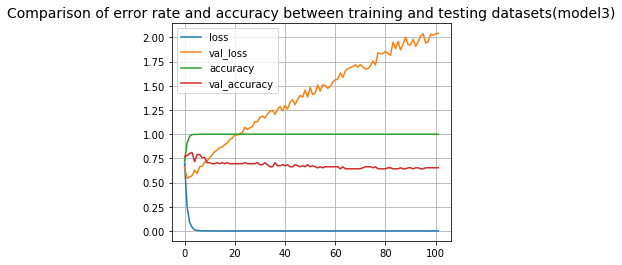

In [26]:
import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm
#fm.get_fontconfig_fonts()
#font_path="D:\\ai\\기말대체\\NanumFontSetup_TTF_GOTHIC\\NanumGothic.ttf"
#font_name = fm.FontProperties(fname=font_path).get_name()
#plt.rc('font', family=font_name, size=12) 
plt.figure(figsize=(5,4))
plt.title('Comparison of error rate and accuracy between training and testing datasets(model3)', fontsize=14)

plt.plot(hist3.history['loss'])      # 학습 데이터셋의 loss   -> loss 
plt.plot(hist3.history['val_loss'])  # 테스트 데이터셋의 loss -> val_loss

plt.plot(hist3.history['accuracy'])      # 학습 데이터셋의 accuracy    -> accuracy 
plt.plot(hist3.history['val_accuracy'])  # 테스트 데이터셋의 accuracy  -> val_accuracy 

plt.legend(['loss','val_loss','accuracy', 'val_accuracy' ])     # 범례
plt.grid()
plt.show()

In [27]:
model3.save('model3.h5')  